# Random Forest

## Band Gap

## Part 1: Train on normalized dataset

In [78]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

%matplotlib inline

I am training the XGBoost model on the normalized bandgap dataset `x_y_bandgap_normalized.csv`

MinMaxScaling was used to normalized the data

The dataset contains:
- 1053 materials
- 36 normalized features (X)
- 1 normalized target column (band gap)

In [79]:
# data check
import pandas as pd
data = pd.read_csv('../processed_data/x_y_bandgap_normalized.csv')

#data.head()
#data.info()
#data.columns

# split data into features (X) and targets (Y)
X = data.drop(columns=['band_gap'])
Y = data['band_gap']

Next, create the training, validation and test sets. We follow the protocall in the original paper: 

*A total of 15% of the data in the original dataset was reserved as the test set, and the remaining data were divided into the training set and the validation set at a ratio of 0.85:0.15.*

Therefore:
- Test set: Randomly selected 15% of the data set

For the remaining 85% of the data set:
- Validation set: 15% 
- Training set: 85%

In [80]:
X_trainval, X_test, Y_trainval, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

X_train, X_val, Y_train, Y_val = train_test_split(X_trainval, Y_trainval, test_size = 0.15, random_state=42)

Next, implement Random Forest

In [81]:
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    max_features='auto',
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=42)

Now we evaluate the model

In [82]:
def eval(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    print(f'{name}: MAE = {mae:0.3f}, RMSE = {rmse:.3f}, R^2 = {r2:.3f}')
    
Y_train_pred = rf.predict(X_train)
Y_val_pred = rf.predict(X_val)
Y_test_pred = rf. predict(X_test)

print("==== Random Forest Results ====")

eval('Train', Y_train, Y_train_pred)
eval('Validation', Y_val, Y_val_pred)
eval('Test', Y_test, Y_test_pred)

==== Random Forest Results ====
Train: MAE = 0.211, RMSE = 0.308, R^2 = 0.971
Validation: MAE = 0.536, RMSE = 0.776, R^2 = 0.808
Test: MAE = 0.539, RMSE = 0.820, R^2 = 0.824


10-fold Cross Validation

In [83]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

r2s = []
maes = []
rmses = []

for train_idx, val_idx in kf.split(X):
    X_train_cv = X.iloc[train_idx]
    Y_train_cv = Y.iloc[train_idx]
    X_val_cv = X.iloc[val_idx]
    Y_val_cv = Y.iloc[val_idx]

    rf_cv = RandomForestRegressor(
        n_estimators=500,
        max_depth=None,
        max_features='auto',
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    )

    rf_cv.fit(X_train_cv, Y_train_cv)
    Y_pred_cv = rf_cv.predict(X_val_cv)

    r2 = r2_score(Y_val_cv, Y_pred_cv)
    r2s.append(r2)
    mae = mean_absolute_error(Y_val_cv, Y_pred_cv)
    maes.append(mae)
    rmse = mean_squared_error(Y_val_cv, Y_pred_cv, squared=False)
    rmses.append(rmse)


print("\nRandom Forest 10-Fold Cross Validation:")
print(f"R^2   mean = {np.mean(r2s):.3f}, std = {np.std(r2s):.3f}")
print(f"MAE  mean = {np.mean(maes):.3f}, std = {np.std(maes):.3f}")
print(f"RMSE mean = {np.mean(rmses):.3f}, std = {np.std(rmses):.3f}")



Random Forest 10-Fold Cross Validation:
R^2   mean = 0.810, std = 0.071
MAE  mean = 0.502, std = 0.054
RMSE mean = 0.768, std = 0.100


Visualize the Performance

In [84]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def plot_cor(Y_train, Y_train_pred,
             Y_val,   Y_val_pred,
             Y_test,  Y_test_pred,
             save_path,
             target_name="bandgap",
             model_name="XGBoost"):


    if target_name.lower() in ["bandgap", "band gap"]:
        axis_label = "Band Gap (eV)"
    elif target_name.lower() in ["formation energy", "formation_energy", "fe"]:
        axis_label = "Formation Energy (eV/atom)"
    else:
        axis_label = target_name

    fig, ax = plt.subplots(figsize=(5, 5))

    ax.scatter(Y_train, Y_train_pred,
               label='Train', alpha=0.4, color='blue')

    ax.scatter(Y_val, Y_val_pred,
               label='Validation', alpha=0.8, color='orange')

    all_true = np.concatenate([Y_train.values, Y_val.values, Y_test.values])
    low = all_true.min()
    high = all_true.max()

    ax.plot([low, high], [low, high],
            '--', color='red', label='Perfect prediction')

    ax.set_xlabel(f"True {axis_label}")
    ax.set_ylabel(f"Predicted {axis_label}")
    ax.set_title(f"{model_name} Predictions vs True Values")
    ax.legend(loc='lower right')
    ax.grid(True)

    rmse_val = mean_squared_error(Y_val, Y_val_pred, squared=False)
    r2_val   = r2_score(Y_val, Y_val_pred)
    mae_val  = mean_absolute_error(Y_val, Y_val_pred)

    textstr = (
        f'Validation R²:  {r2_val:.4f}\n'
        f'Validation MAE: {mae_val:.4f}\n'
        f'Validation MSE:{rmse_val:.4f}'
    )

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.05, 0.95, textstr,
            transform=ax.transAxes,
            fontsize=11,
            verticalalignment='top',
            bbox=props,
            family='monospace')

    plt.tight_layout()
    plt.savefig(save_path, dpi=600, bbox_inches="tight")
    print(f"Plot saved to: {save_path}")
    plt.show()

Plot saved to: RF_bg_36_cor.png


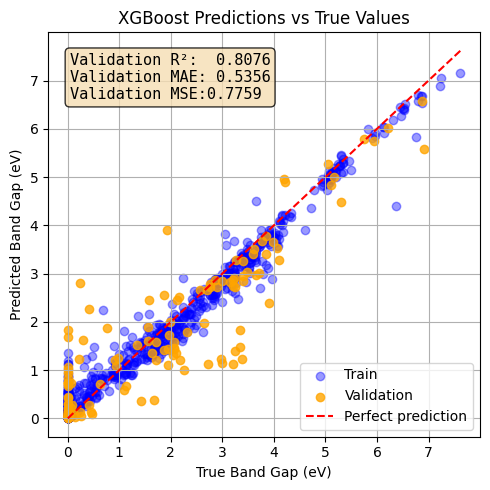

In [85]:
Y_train_pred = rf.predict(X_train)
Y_val_pred   = rf.predict(X_val)
Y_test_pred  = rf.predict(X_test)

plot_cor(Y_train, Y_train_pred,
             Y_val,   Y_val_pred,
             Y_test,  Y_test_pred,
             save_path = 'RF_bg_36_cor.png', target_name="bandgap")


In [86]:
def comps(Y_test, Y_test_pred,paper_mae=0.211, paper_rmse=0.259, paper_r2=0.934,title="Test Set Comparison"):
    
    mae  = mean_absolute_error(Y_test, Y_test_pred)
    rmse = mean_squared_error(Y_test, Y_test_pred, squared=False)
    r2   = r2_score(Y_test, Y_test_pred)
    
    labels = ["MAE", "RMSE", "R^2"]
    present_study = [mae, rmse, r2]
    paper_scores  = [paper_mae, paper_rmse, paper_r2]

    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(5,4))
    plt.bar(x - width/2, present_study, width,
            label="Present Study", color='deepskyblue')
    plt.bar(x + width/2, paper_scores, width,
            label="Paper (XGBoost)", color='yellowgreen')

    plt.xticks(x, labels)
    plt.ylabel("Score")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

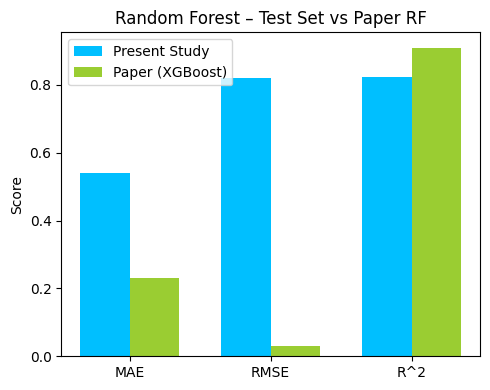

In [87]:
Y_test_pred = rf.predict(X_test)

paper_mae_rf  = 0.230   
paper_rmse_rf = 0.0293   
paper_r2_rf   = 0.909   

comps(Y_test, Y_test_pred,
      paper_mae=paper_mae_rf,
      paper_rmse=paper_rmse_rf,
      paper_r2=paper_r2_rf,
      title="Random Forest – Test Set vs Paper RF")

## Part 2: Train using the same features as the paper

    In the bandgap prediction, a total of 23 relevant features, 
    namely the 
    
    1. electronegativity of the A-site atom, 
    2. B′-site atom
    3. B″-site atom (χ_A, χ_B′ and χ_B″)
    4. atomic mass of the A-site
    5. B′-site elements (M_A and M_B′), 
    6. electronic affinity of the A-site
    7. X-site elements (EA_A and EA_X), 
    8. atomic number of the B″-site element (Z_B″)
    9. first ionization energy of the A-site
    10. B′-site
    11. B″-site
    12. X-site elements (IE1_A, IE1_B′, IE1_B″ and IE1_X)
    13. second ionization energy of the A-site
    14. B′-site elements (IE2_A and IE2_B′)
    15. melting-point temperature of the A-site, 
    16. B′-site
    17. B″-site
    18. X-site elements (Tm_A, Tm_B′, Tm_B″ and Tm_X)
    19. boiling-point temperature of the A-site
    20. B′-site elements (Tb_A and Tb_B′), 
    21. van der Waals radius of the A-site element (Rv_A)
    22. third ionization energy of the B′-site
    23. B″-site elements (IE3_B′ and IE3_B″) 

    were finally retained, and the Pearson correlation diagram of these features was drawn, as shown in Figure 1a.

In [88]:
# extract the features into a new csv

import pandas as pd

raw = pd.read_excel("/Users/alisonrhoads/Downloads/supplementary_data_and_dataset_3/data_set_1053.xlsx")

paper_features = [
    "A_electronegativity",          # χ_A
    "B1_electronegativity",         # χ_B′
    "B2_electronegativity",         # χ_B″
    "A_atomic_mass",                # M_A
    "B1_atomic_mass",               # M_B′
    "A_electron_affinity",          # EA_A
    "X_electron_affinity",          # EA_X
    "B2_atomic_number",             # Z_B″
    "A_first_ionization_energy",    # IE1_A
    "B1_first_ionization_energy",   # IE1_B′
    "B2_first_ionization_energy",   # IE1_B″
    "X_first_ionization_energy",    # IE1_X
    "A_second_ionization_energy",   # IE2_A
    "B1_second_ionization_energy",  # IE2_B′
    "A_melting_point",              # Tm_A
    "B1_melting_point",             # Tm_B′
    "B2_melting_point",             # Tm_B″
    "X_melting_point",              # Tm_X
    "A_boiling_point",              # Tb_A
    "B1_boiling_point",             # Tb_B′
    "A_van_der_waals_radius",       # Rv_A
    "B1_third_ionization_energy",   # IE3_B′
    "B2_third_ionization_energy",   # IE3_B″
]

paper_dataset = raw[paper_features + ["band_gap"]]

output_path = "../processed_data/bandgap_23_features.csv"
paper_dataset.to_csv(output_path, index=False)

print("Saved formation energy feature set to:", output_path)

Saved formation energy feature set to: ../processed_data/bandgap_23_features.csv


In [89]:
#!pip install --upgrade openpyxl

In [90]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

paper_features = [
    "A_electronegativity",          # χ_A
    "B1_electronegativity",         # χ_B′
    "B2_electronegativity",         # χ_B″
    "A_atomic_mass",                # M_A
    "B1_atomic_mass",               # M_B′
    "A_electron_affinity",          # EA_A
    "X_electron_affinity",          # EA_X
    "B2_atomic_number",             # Z_B″
    "A_first_ionization_energy",    # IE1_A
    "B1_first_ionization_energy",   # IE1_B′
    "B2_first_ionization_energy",   # IE1_B″
    "X_first_ionization_energy",    # IE1_X
    "A_second_ionization_energy",   # IE2_A
    "B1_second_ionization_energy",  # IE2_B′
    "A_melting_point",              # Tm_A
    "B1_melting_point",             # Tm_B′
    "B2_melting_point",             # Tm_B″
    "X_melting_point",              # Tm_X
    "A_boiling_point",              # Tb_A
    "B1_boiling_point",             # Tb_B′
    "A_van_der_waals_radius",       # Rv_A
    "B1_third_ionization_energy",   # IE3_B′
    "B2_third_ionization_energy",   # IE3_B″
]


raw = pd.read_excel("/Users/alisonrhoads/Downloads/supplementary_data_and_dataset_3/data_set_1053.xlsx")

X_raw = raw[paper_features]
Y = raw["band_gap"]


scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_raw), columns=paper_features)

# Train/val/test split
X_trainval, X_test, Y_trainval, Y_test = train_test_split(
    X_scaled, Y, test_size=0.15, random_state=42
)

X_train, X_val, Y_train, Y_val = train_test_split(
    X_trainval, Y_trainval, test_size=0.15, random_state=42
)

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    max_features='auto',
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, Y_train)

def eval_block(name, Y_true, Y_pred):
    r2 = r2_score(Y_true, Y_pred)
    mse = mean_squared_error(Y_true, Y_pred)
    rmse = mean_squared_error(Y_true, Y_pred, squared=False)
    mae = mean_absolute_error(Y_true, Y_pred)
    print(f"{name}: MAE={mae:.3f}, MSE={mse:.3f}, RMSE={rmse:.3f}, R^2={r2:.3f}")

print("==== Random Forest (23 paper features) ====")
Y_train_pred = rf.predict(X_train)
Y_val_pred   = rf.predict(X_val)
Y_test_pred  = rf.predict(X_test)

eval_block("Train", Y_train, Y_train_pred)
eval_block("Val  ", Y_val,   Y_val_pred)
eval_block("Test ", Y_test,  Y_test_pred)

==== Random Forest (23 paper features) ====
Train: MAE=0.206, MSE=0.095, RMSE=0.308, R^2=0.971
Val  : MAE=0.510, MSE=0.572, RMSE=0.756, R^2=0.817
Test : MAE=0.519, MSE=0.691, RMSE=0.831, R^2=0.819


Plot saved to: RF_BG_23_cor.png


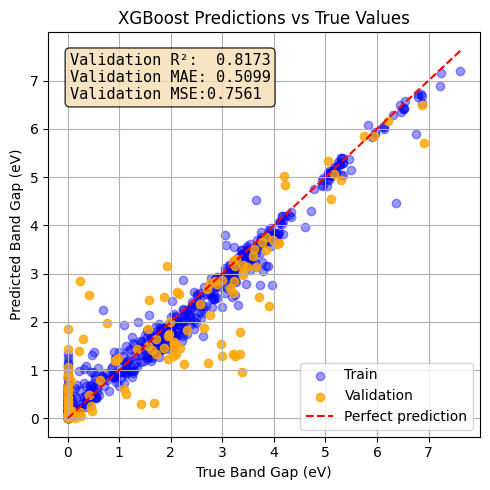

In [91]:
Y_train_pred = rf.predict(X_train)
Y_val_pred   = rf.predict(X_val)
Y_test_pred  = rf.predict(X_test)

plot_cor(Y_train, Y_train_pred,
             Y_val,   Y_val_pred,
             Y_test,  Y_test_pred,
             save_path='RF_BG_23_cor.png',target_name="bandgap")

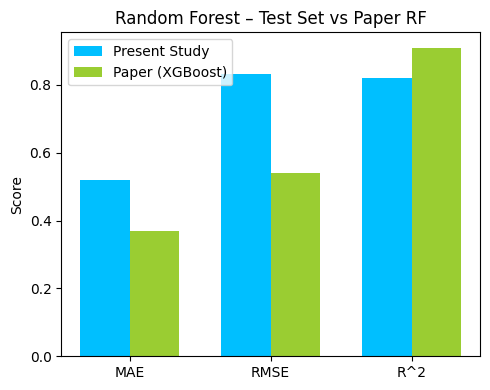

In [92]:
Y_test_pred = rf.predict(X_test)

paper_r2_rf   = 0.909
paper_mae_rf  = 0.370
paper_rmse_rf = 0.541   # sqrt(0.293)

comps(Y_test, Y_test_pred,
      paper_mae=paper_mae_rf,
      paper_rmse=paper_rmse_rf,
      paper_r2=paper_r2_rf,
      title="Random Forest – Test Set vs Paper RF")

## Formation Energy

## Part 1: Normalized Data Set

In [93]:
# data check
import pandas as pd
data = pd.read_csv('../processed_data/x_y_formation_normalized.csv')

#data.head()
#data.info()
#data.columns

# split data into features (X) and targets (Y)
X = data.drop(columns=['formation_energy'])
Y = data['formation_energy']


X_trainval, X_test, Y_trainval, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

X_train, X_val, Y_train, Y_val = train_test_split(X_trainval, Y_trainval, test_size = 0.15, random_state=42)
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    max_features='auto',
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, Y_train)

def eval(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    print(f'{name}: MAE = {mae:0.3f}, RMSE = {rmse:.3f}, R^2 = {r2:.3f}')
    
Y_train_pred = rf.predict(X_train)
Y_val_pred = rf.predict(X_val)
Y_test_pred = rf. predict(X_test)

print("==== Random Forest Results ====")

eval('Train', Y_train, Y_train_pred)
eval('Validation', Y_val, Y_val_pred)
eval('Test', Y_test, Y_test_pred)

kf = KFold(n_splits=10, shuffle=True, random_state=42)

r2s = []
maes = []
rmses = []

for train_idx, val_idx in kf.split(X):
    X_train_cv = X.iloc[train_idx]
    Y_train_cv = Y.iloc[train_idx]
    X_val_cv = X.iloc[val_idx]
    Y_val_cv = Y.iloc[val_idx]

    rf_cv = RandomForestRegressor(
        n_estimators=500,
        max_depth=None,
        max_features='auto',
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    )

    rf_cv.fit(X_train_cv, Y_train_cv)
    Y_pred_cv = rf_cv.predict(X_val_cv)

    r2 = r2_score(Y_val_cv, Y_pred_cv)
    r2s.append(r2)
    mae = mean_absolute_error(Y_val_cv, Y_pred_cv)
    maes.append(mae)
    rmse = mean_squared_error(Y_val_cv, Y_pred_cv, squared=False)
    rmses.append(rmse)


print("\nRandom Forest 10-Fold Cross Validation:")
print(f"R^2   mean = {np.mean(r2s):.3f}, std = {np.std(r2s):.3f}")
print(f"MAE  mean = {np.mean(maes):.3f}, std = {np.std(maes):.3f}")
print(f"RMSE mean = {np.mean(rmses):.3f}, std = {np.std(rmses):.3f}")

==== Random Forest Results ====
Train: MAE = 0.043, RMSE = 0.090, R^2 = 0.969
Validation: MAE = 0.107, RMSE = 0.179, R^2 = 0.885
Test: MAE = 0.116, RMSE = 0.254, R^2 = 0.742

Random Forest 10-Fold Cross Validation:
R^2   mean = 0.808, std = 0.101
MAE  mean = 0.107, std = 0.015
RMSE mean = 0.220, std = 0.074


Plot saved to: RF_FE_37_cor.png


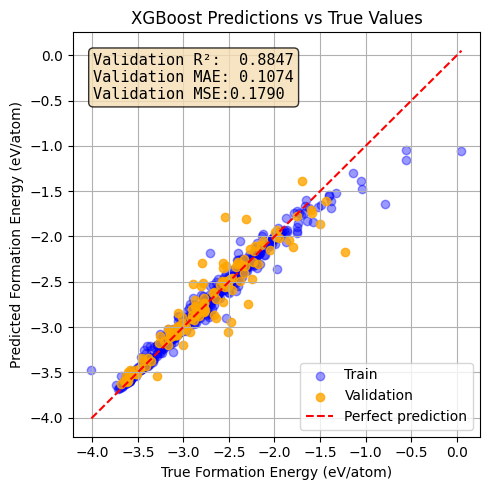

In [94]:
plot_cor(Y_train, Y_train_pred, Y_val, Y_val_pred, Y_test, Y_test_pred, save_path = 'RF_FE_37_cor.png', target_name="formation energy")

## Part 2: Train using the same features as the paper

In [95]:
# extract the features into a new csv

import pandas as pd

raw = pd.read_excel("/Users/alisonrhoads/Downloads/supplementary_data_and_dataset_3/data_set_1053.xlsx")

fe_features = [
    "B2_ionic_radius",            # R_B'' 
    "A_electronegativity",        # χ_A
    "B1_electronegativity",       # χ_B'
    "B2_electronegativity",       # χ_B''
    "B1_electron_affinity",       # EA_B'
    "B2_electron_affinity",       # EA_B''
    "X_electron_affinity",        # EA_X
    "B1_first_ionization_energy", # IE1_B'
    "X_first_ionization_energy",  # IE1_X
    "A_second_ionization_energy", # IE2_A
    "B1_second_ionization_energy",# IE2_B'
    "A_melting_point",            # Tm_A
    "B1_melting_point",           # Tm_B'
    "B1_thermal_conductivity",    # k_B'
    "A_boiling_point",            # Tb_A
    "B1_boiling_point",           # Tb_B'
    "X_boiling_point",            # Tb_X
    "X_third_ionization_energy",  # IE3_X
]

fe_dataset = raw[fe_features + ["formation_energy"]]

output_path = "../processed_data/formation_energy_18_features.csv"
fe_dataset.to_csv(output_path, index=False)

print("Saved formation energy feature set to:", output_path)

Saved formation energy feature set to: ../processed_data/formation_energy_18_features.csv


In [96]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

paper_features = [
    "B2_ionic_radius",            # R_B'' (B''-site ionic radius)
    "A_electronegativity",        # χ_A
    "B1_electronegativity",       # χ_B'
    "B2_electronegativity",       # χ_B''
    "B1_electron_affinity",       # EA_B'
    "B2_electron_affinity",       # EA_B''
    "X_electron_affinity",        # EA_X
    "B1_first_ionization_energy", # IE1_B'
    "X_first_ionization_energy",  # IE1_X
    "A_second_ionization_energy", # IE2_A
    "B1_second_ionization_energy",# IE2_B'
    "A_melting_point",            # Tm_A
    "B1_melting_point",           # Tm_B'
    "B1_thermal_conductivity",    # k_B'
    "A_boiling_point",            # Tb_A
    "B1_boiling_point",           # Tb_B'
    "X_boiling_point",            # Tb_X
    "X_third_ionization_energy",  # IE3_X
]


raw = pd.read_excel("/Users/alisonrhoads/Downloads/supplementary_data_and_dataset_3/data_set_1053.xlsx")

X_raw = raw[paper_features]
Y = raw["formation_energy"]

scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_raw), columns=paper_features)

# Train/val/test split
X_trainval, X_test, Y_trainval, Y_test = train_test_split(
    X_scaled, Y, test_size=0.15, random_state=42
)

X_train, X_val, Y_train, Y_val = train_test_split(
    X_trainval, Y_trainval, test_size=0.15, random_state=42
)

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    max_features='auto',
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, Y_train)

def eval_block(name, Y_true, Y_pred):
    r2 = r2_score(Y_true, Y_pred)
    mse = mean_squared_error(Y_true, Y_pred)
    rmse = mean_squared_error(Y_true, Y_pred, squared=False)
    mae = mean_absolute_error(Y_true, Y_pred)
    print(f"{name}: MAE={mae:.3f}, MSE={mse:.3f}, RMSE={rmse:.3f}, R^2={r2:.3f}")

print("==== Random Forest (23 paper features) ====")
Y_train_pred = rf.predict(X_train)
Y_val_pred   = rf.predict(X_val)
Y_test_pred  = rf.predict(X_test)

eval_block("Train", Y_train, Y_train_pred)
eval_block("Val  ", Y_val,   Y_val_pred)
eval_block("Test ", Y_test,  Y_test_pred)

==== Random Forest (23 paper features) ====
Train: MAE=0.042, MSE=0.008, RMSE=0.090, R^2=0.969
Val  : MAE=0.106, MSE=0.030, RMSE=0.173, R^2=0.892
Test : MAE=0.117, MSE=0.066, RMSE=0.257, R^2=0.737


Plot saved to: RF_FE_18_cor.png


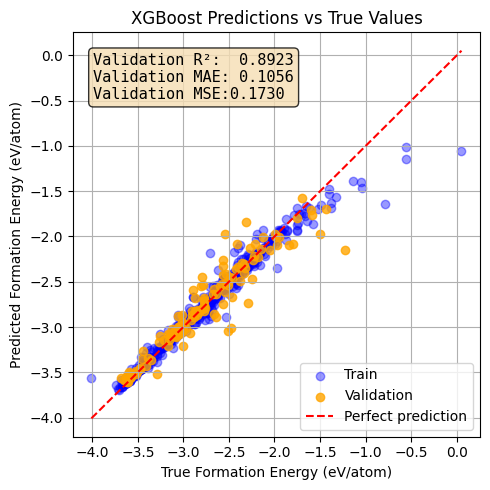

In [97]:
Y_train_pred = rf.predict(X_train)
Y_val_pred   = rf.predict(X_val)
Y_test_pred  = rf.predict(X_test)

plot_cor(Y_train, Y_train_pred, Y_val, Y_val_pred, Y_test, Y_test_pred, save_path = 'RF_FE_18_cor.png', target_name="formation energy")